### Notebook to create historical data from the France climate reanalysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import gzip
from scipy.stats import fisk, norm
import xarray as xr

In [3]:
path_list = ['https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/REF_CC/SIM/QUOT_SIM2_previous-2020-202503.csv.gz',
            ' https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/REF_CC/SIM/QUOT_SIM2_2010-2019.csv.gz',
            'https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/REF_CC/SIM/QUOT_SIM2_2000-2009.csv.gz',
            'https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/REF_CC/SIM/QUOT_SIM2_1990-1999.csv.gz',
            'https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/REF_CC/SIM/QUOT_SIM2_1980-1989.csv.gz',
            'https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/REF_CC/SIM/QUOT_SIM2_1970-1979.csv.gz',
            'https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/REF_CC/SIM/QUOT_SIM2_latest-20250301-20250426.csv.gz']

output_path = '../../data/SAFRAN/'

In [137]:
df_meta = pd.read_csv('C:/Users/colin/Downloads/coordonnees_grille_safran_lambert-2-etendu.csv', sep=';', encoding='latin1')
# Ajoute une colonne 'ID' avec la concaténation des 2 colonnes  LAMBX et LAMBY
df_meta['ID'] = df_meta['LAMBX (hm)'].astype(str) + '_' + df_meta['LAMBY (hm)'].astype(str)
# supprime les colonnes 'LAMBX (hm)' et 'LAMBY (hm)'
df_meta.drop(['LAMBX (hm)', 'LAMBY (hm)'], axis=1, inplace=True)
# index sur la colonne 'ID'
df_meta = df_meta.set_index(['ID'], drop=True)
# display(df_meta)
df_meta['LAT_DG'] = df_meta['LAT_DG'].str.replace(',', '.').astype(float)
df_meta['LON_DG'] = df_meta['LON_DG'].str.replace(',', '.').astype(float)

# jointure des 2 dataframes en plaçant les nouvelles colonnes au début
df_meta

,LAT_DG,LON_DG
ID,,
600_24010,48.3822,-4.96118
760_24170,48.5386,-4.76561
760_24090,48.4670,-4.75585
760_24010,48.3953,-4.74612
760_23930,48.3237,-4.73641
...,...,...
11960_17290,42.3189,9.55634
11960_17210,42.2473,9.54748
11960_17130,42.1758,9.53863


In [5]:
import matplotlib.pyplot as plt
import pyproj
import xarray as xr
import numpy as np

In [6]:
df_spei = pd.read_csv('C:/Users/colin/Downloads/spei.csv', sep=',', encoding='latin1')

In [ ]:
df_spei]

,ID,year,month,time,def_pr,spei
0,1000_23290,1970,1,1970-01-16 00:00:00,2.699792,1.142342
1,1000_23290,1970,2,1970-02-14 12:00:00,2.380476,1.007828
2,1000_23290,1970,3,1970-03-16 00:00:00,0.309462,0.076555
3,1000_23290,1970,4,1970-04-15 12:00:00,-0.294667,-0.238048
4,1000_23290,1970,5,1970-05-16 00:00:00,-1.796452,-1.019978
...,...,...,...,...,...,...
6568283,9960_25050,2024,12,2024-12-16 00:00:00,2.274086,1.019817
6568284,9960_25050,2025,1,2025-01-16 00:00:00,1.936022,0.839519
6568285,9960_25050,2025,2,2025-02-14 12:00:00,0.943690,0.310207
6568286,9960_25050,2025,3,2025-03-16 00:00:00,-1.147043,-0.925408


In [2]:
def change_projection(da,plot=False):
    if plot:
        da.plot()
        plt.show()
        plt.close()
    new_lon_coords = np.linspace(-5, 9.8,134)
    new_lat_coords = np.linspace(41.3, 51.3, 143)
    lonmesh, latmesh = np.meshgrid(new_lon_coords, new_lat_coords)
    target_crs = pyproj.CRS(init="epsg:4326") # Coordinate system of the file
    # rp = ccrs.RotatedPole(pole_longitude=-162.0, pole_latitude=39.25)
    source_crs = pyproj.CRS(init="epsg:27572")
    latlon_to_rotpol = pyproj.Transformer.from_crs(target_crs, source_crs)
    x_om2, y_om2 = latlon_to_rotpol.transform(lonmesh, latmesh)
    x_om2 = xr.DataArray(x_om2, dims=('lat','lon'))
    y_om2 = xr.DataArray(y_om2, dims=('lat','lon'))
    da = da.interp({'x':x_om2, 'y':y_om2}, method='nearest').load()
    da = da.assign_coords({'lon': (('lon'),new_lon_coords), 'lat': (('lat'), new_lat_coords)}).drop_vars(['lon','lat'])
    da['lon'] = new_lon_coords
    da['lat'] = new_lat_coords
    if plot:
        da.plot()
        plt.show()
        plt.close()
    da = da.rename({'lon':'longitude','lat':'latitude'})
    da.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    da.rio.write_crs(target_crs, inplace=True)
    return da

In [140]:
target = ['43.45730103449103', '3.4304254493868296']
target = ['48.82944126201081', '2.3695145265963538']
#find the closest point in the dataframe to the target coordinates
df_meta['distance'] = np.sqrt((df_meta['LAT_DG'] - float(target[0]))**2 + (df_meta['LON_DG'] - float(target[1]))**2)
closest_point = df_meta.loc[df_meta['distance'].idxmin()]
closest_point

LAT_DG      48.823500
LON_DG       2.391640
distance     0.022909
Name: 6040_24250, dtype: float64

In [3]:

def download_file(url, output_path):
    # Get the filename from the URL
    filename = url.split('/')[-1]
    output_file = os.path.join(output_path, filename)

    # Download the file
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_file, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {filename} to {output_path}")
    else:
        print(f"Failed to download {filename}")

In [4]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

# for path in path_list:
#     download_file(path, output_path)

In [13]:
#open one df
path_list = [os.path.join(output_path, path.split('/')[-1]) for path in path_list]
path_list[-1]

colnames = ['LAMBX', 'LAMBY', 'DATE', 'PRELIQ_Q', 'T_Q', 'TSUP_H_Q', 'ETP_Q', 'SWI_Q']

# import xarray as xr
# import dask.dataframe as dd

# # Load the data into a Dask DataFrame
# ddf = dd.read_csv(path_list[0], compression='gzip', sep=';', header=0, names=colnames, sample_rows=10000,
#                   dtype={'LAMBX': 'float32', 'LAMBY': 'float32', 'DATE': 'str', 'PE_Q': 'float32', 
#                          'T_Q': 'float32', 'TSUP_H_Q': 'float32', 'ETP_Q': 'float32', 'SWI_Q': 'float32'}, 
#                   blocksize=None)

# # Convert the 'DATE' column to datetime format
# ddf['DATE'] = dd.to_datetime(ddf['DATE'], format='%Y%m%d%H%M')

# #convert toxarray
# ds = ddf.set_index('DATE').to_dask_array(lengths=True)


# # # Compute the Dask DataFrame to get a Pandas DataFrame
# df = ddf.compute()
path_list[-1]

'../../data/SAFRAN/QUOT_SIM2_latest-20250301-20250426.csv.gz'

In [14]:
df = pd.read_csv(path_list[-1], compression='gzip', sep=';', header=0)
df = df[colnames]
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
df['ID'] = df['LAMBX'].astype(str) + '_' + df['LAMBY'].astype(str)
df.drop(['LAMBX', 'LAMBY'], axis=1, inplace=True)
# index sur les 2 colonnes 'DATE' et 'ID'
df['DATE']= pd.to_datetime(df["DATE"].values, format='%Y%m%d').values
df = df.rename(columns={'PRELIQ_Q': 'prec', 'T_Q': 'temperature',
                   'TSUP_H_Q': 'temperature_max', 'ETP_Q': 'evapotranspiration', 'SWI_Q': 'soil_moisture', 'DATE': 'time'})
df.set_index('time', inplace=True)
df.set_index('ID', append=True, inplace=True)
df = df_meta.join(df, how='inner')
df = df.to_xarray()

df['LAT_DG'] = df['LAT_DG'].str.replace(',', '.').astype(float).mean(dim='time')
df['LON_DG'] = df['LON_DG'].str.replace(',', '.').astype(float).mean(dim='time')

df.to_netcdf('C:/Users/colin/Downloads/safran.nc', mode='w', format='NETCDF4', engine='netcdf4')

In [118]:
import xagg as xa
import geopandas as gpd

lau_2023 = gpd.read_file('../../data/LAU_2023_EU/LAU_RG_01M_2023_4326.shp')
lau_2023 = lau_2023[lau_2023['CNTR_CODE'] == 'FR']

lau_2023 = lau_2023.to_crs(epsg=4326)

In [ ]:
#for each lau_2023 select the closest pixel in df
lau_2023['centroid_x'] = lau_2023.geometry.centroid.x
lau_2023['centroid_y'] = lau_2023.geometry.centroid.y

lau_2023['centroid_x'] = lau_2023['centroid_x'].astype(float)
lau_2023['centroid_y'] = lau_2023['centroid_y'].astype(float)

#find the closest pixel in df for each lau_2023 in df_meta to keep it
df_centroid = df_meta[['LAT_DG', 'LON_DG']].reset_index()
df_centroid['LAT_DG'] = df_centroid['LAT_DG'].str.replace(',', '.').astype(float)
df_centroid['LON_DG'] = df_centroid['LON_DG'].str.replace(',', '.').astype(float)

df_closest = lau_2023[['LAU_ID', 'centroid_x', 'centroid_y']].copy()
for index, row in lau_2023.iterrows():
    # Calculate the distance between the centroid and each pixel in df_meta
    df_centroid['distance'] = np.sqrt((df_centroid['LAT_DG'] - row['centroid_y'])**2 + (df_centroid['LON_DG'] - row['centroid_x'])**2)
    # Find the index of the closest pixel
    closest_index = df_centroid['distance'].idxmin()
    # Get the ID of the closest pixel
    closest_id = df_centroid.loc[closest_index, 'ID']
    
    # Add the ID to the df_closest DataFrame
    df_closest.at[index, 'closest_id'] = closest_id
    df_closest.at[index, 'closest_distance'] = df_centroid.loc[closest_index, 'distance']


C:\Users\colin\AppData\Local\Temp\ipykernel_23216\1366353630.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lau_2023['centroid_x'] = lau_2023.geometry.centroid.x
C:\Users\colin\AppData\Local\Temp\ipykernel_23216\1366353630.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lau_2023['centroid_y'] = lau_2023.geometry.centroid.y


In [ ]:

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-5, 10, 41, 51], crs=ccrs.PlateCarree())

df_plot = df.copy()
df_plot = df_plot.dropna(dim='ID')
lon = df_plot['LON_DG'].values
lat = df_plot['LAT_DG'].values

#make a cross for each lat, lon
for i in range(len(lon)):
    ax.plot(lon[i], lat[i], 'r+', markersize=5, transform=ccrs.PlateCarree())

In [124]:
df_plot = df.prec.mean(dim='time').to_dataframe().reset_index()
#extract based on df_closest.closest_id
df_plot = df_closest[['LAU_ID', 'closest_id']].merge(df_plot, left_on='closest_id', right_on='ID', how='left')
df_plot

df_plot[df_plot['LAU_ID'] == '75056']

,LAU_ID,closest_id,ID,prec
18524,75056,6040_24250,6040_24250,0.959649


In [125]:
lau_2023 = lau_2023.merge(df_plot[['LAU_ID', 'prec']], left_on='LAU_ID', right_on='LAU_ID', how='left')
lau_2023[lau_2023['LAU_ID'] == '75056']

,GISCO_ID,CNTR_CODE,LAU_ID,LAU_NAME,POP_2023,POP_DENS_2,AREA_KM2,YEAR,geometry,temperature_max,prec
18524,FR_75056,FR,75056,Paris,2165423.0,NaN,20563.64776,2023,"POLYGON ((2.41531 48.85517, 2.41634 48.84923, ...",15.331579,0.959649


Text(0.5, 1.0, 'Maximum Temperature (°C)')

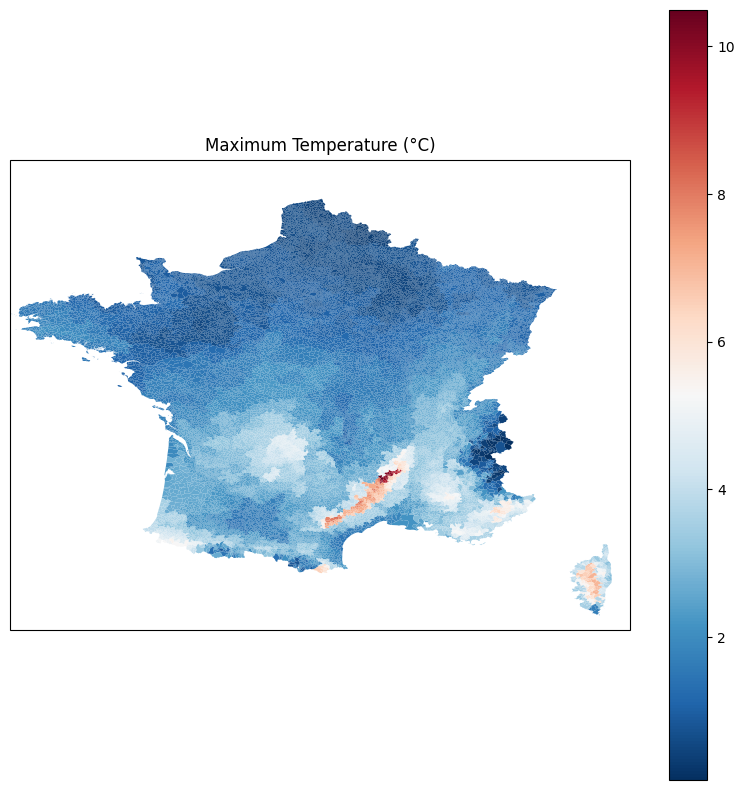

In [126]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig,ax = plt.subplots(1,1, figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
lau_2023.plot(column='prec', legend=True, cmap='RdBu_r', ax=ax, linewidth=1.2, transform=ccrs.PlateCarree())
ax.set_extent([-5, 10, 41, 52], crs=ccrs.PlateCarree())
ax.set_title('Maximum Temperature (°C)')

In [147]:
def_pr = (df.prec - df.evapotranspiration).rolling(time=30).mean(dim='time')
def_pr = def_pr.dropna(dim='time')
#parameter
def_pr = def_pr.to_dataframe(name='def_pr').reset_index()
def_pr

C:\Users\colin\AppData\Local\Temp\ipykernel_23216\1727100166.py:1: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  def_pr = (df.prec - df.evapotranspiration).rolling(time=30).mean(dim='time')


,time,ID,def_pr
0,2025-03-30,1000_23290,-0.870000
1,2025-03-30,1000_23370,-0.853333
2,2025-03-30,1000_23450,-0.843333
3,2025-03-30,1000_23530,-0.440000
4,2025-03-30,1000_23610,-0.780000
...,...,...,...
276971,2025-04-26,9960_24730,-1.536667
276972,2025-04-26,9960_24810,-1.536667
276973,2025-04-26,9960_24890,-1.470000
276974,2025-04-26,9960_24970,-1.476667


In [157]:
import numpy as np
import pandas as pd
from scipy.stats import fisk, norm

def standardize_loglogistic(dataframe, column):
    """
    Standardize a column of a dataframe using a 3-parameter log-logistic distribution.

    Parameters:
    - dataframe: pandas DataFrame
    - column: column name (str) to standardize

    Returns:
    - dataframe: same DataFrame with an added column '<column>_standardized'
    """

    x = dataframe[column].dropna()

    # Fit the 3-parameter log-logistic distribution (fisk in scipy)
    # fisk in scipy is parameterized by c (shape), loc (location), scale (scale)
    params = fisk.fit(x)  # force location=0 if needed, else remove floc=0

    c, loc, scale = params
    print(f"Fitted parameters: shape={c}, loc={loc}, scale={scale}")

    # Calculate cumulative probability (CDF) for each value
    cdf_values = fisk.cdf(dataframe[column], c, loc=loc, scale=scale)

    # Avoid CDF values of exactly 0 or 1 (to avoid infinite z-scores)
    cdf_values = np.clip(cdf_values, 1e-6, 1 - 1e-6)

    # Transform CDF to standard normal quantiles
    standardized = norm.ppf(cdf_values)

    # Add the standardized column
    dataframe[f"{column}_standardized"] = standardized

    return dataframe


In [160]:
df = standardize_loglogistic(def_pr[def_pr['ID']=='1000_23290'], 'def_pr')
df

Fitted parameters: shape=6.754097858958545, loc=-3.657688663388603, scale=2.8803914856222663


C:\Users\colin\AppData\Local\Temp\ipykernel_23216\1282181240.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[f"{column}_standardized"] = standardized


,time,ID,def_pr,def_pr_standardized
0,2025-03-30,1000_23290,-0.870000,-0.138339
9892,2025-03-31,1000_23290,-0.913333,-0.204380
19784,2025-04-01,1000_23290,-1.010000,-0.354514
29676,2025-04-02,1000_23290,-1.076667,-0.460045
39568,2025-04-03,1000_23290,-0.890000,-0.168716
49460,2025-04-04,1000_23290,-0.873333,-0.143389
59352,2025-04-05,1000_23290,-0.920000,-0.214613
69244,2025-04-06,1000_23290,-0.986667,-0.317943
79136,2025-04-07,1000_23290,-1.090000,-0.481323
89028,2025-04-08,1000_23290,-1.386667,-0.965190


In [20]:
def closest_id(shapefile):
    shapefile['centroid_x'] = shapefile.geometry.centroid.x
    shapefile['centroid_y'] = shapefile.geometry.centroid.y

    shapefile['centroid_x'] = shapefile['centroid_x'].astype(float)
    shapefile['centroid_y'] = shapefile['centroid_y'].astype(float)

    df_meta = pd.read_csv('/gpfs/workdir/shared/juicce/land_use/data/SAFRAN/coordonnees_grille_safran_lambert-2-etendu.csv', sep=';', encoding='latin1')
    df_meta['ID'] = df_meta['LAMBX (hm)'].astype(str) + '_' + df_meta['LAMBY (hm)'].astype(str)
    df_meta.drop(['LAMBX (hm)', 'LAMBY (hm)'], axis=1, inplace=True)
    df_meta = df_meta.set_index(['ID'], drop=True)

    #find the closest pixel in df for each lau_2023 in df_meta to keep it
    df_centroid = df_meta[['LAT_DG', 'LON_DG']].reset_index()
    df_centroid['LAT_DG'] = df_centroid['LAT_DG'].str.replace(',', '.').astype(float)
    df_centroid['LON_DG'] = df_centroid['LON_DG'].str.replace(',', '.').astype(float)

    df_closest = shapefile[['LAU_ID', 'centroid_x', 'centroid_y']].copy()
    for index, row in shapefile.iterrows():
        # Calculate the distance between the centroid and each pixel in df_meta
        df_centroid['distance'] = np.sqrt((df_centroid['LAT_DG'] - row['centroid_y'])**2 + (df_centroid['LON_DG'] - row['centroid_x'])**2)
        # Find the index of the closest pixel
        closest_index = df_centroid['distance'].idxmin()
        # Get the ID of the closest pixel
        closest_id = df_centroid.loc[closest_index, 'ID']
        
        # Add the ID to the df_closest DataFrame
        df_closest.at[index, 'closest_id'] = closest_id
        df_closest.at[index, 'closest_distance'] = df_centroid.loc[closest_index, 'distance']
    return df_closest[['LAU_ID', 'closest_id']]


def parameters_loglogistic(dataframe, column):
    x = dataframe[column].dropna()
    params = fisk.fit(x)
    c, loc, scale = params
    return c, loc, scale

def standardize_loglogistic(c, loc, scale, dataframe, column):
    cdf_values = fisk.cdf(dataframe[column], c, loc=loc, scale=scale)
    cdf_values = np.clip(cdf_values, 1e-6, 1 - 1e-6)
    standardized = norm.ppf(cdf_values)
    dataframe[f"{column}_standardized"] = standardized
    return dataframe

def load_shapefile(shapefile_path, france=False):
    nuts3 = gpd.read_file(shapefile_path)
    nuts3['geometry'] = nuts3.buffer(1000)
    nuts3 = nuts3.to_crs("EPSG:4326")
    if france:
        nuts3 = nuts3[nuts3['CNTRY'] == 'FR']
    nuts3 = nuts3[['LAU_ID', 'geometry', 'LAU_NAME', 'POP_2023', 'AREA_KM2', 'NUTS3_ID']]
    nuts3 = nuts3.to_crs("EPSG:4326")
    return nuts3

def make_spei(paths_list, shapefile_path, spei_path):
    # Load the shapefile
    # nuts3 = load_shapefile(shapefile_path, france=True)
    # # Get the closest id for each LAU_ID
    # df_closest = closest_id(nuts3)
    # Load the SAFRAN data
    ds = xr.open_mfdataset(paths_list, combine='by_coords', parallel=True)
    # Reproject the data to the shapefile CRS
    ds['def_pr'] = ds['prec'] - ds['evapotranspiration']
    ds['def_pr'] = ds['def_pr'].rolling(time=30, center=True).mean()
    ds = ds['def_pr']
    # Initialize lists to store parameters
    def compute_parameters(group):
        # Calculate the log-logistic parameters for the 'def_pr' column
        c, loc, scale = parameters_loglogistic(group, 'def_pr')
        return pd.Series({'c': c, 'loc': loc, 'scale': scale})

    # Group the dataset by 'ID' and compute parameters for each group
    parameters_df = ds.sel(time=slice('1970-01-01', '1999-12-31')).to_dataframe().groupby('ID').apply(compute_parameters).reset_index()

    # Extract the parameters into separate lists
    c_list = parameters_df['c'].tolist()
    loc_list = parameters_df['loc'].tolist()
    scale_list = parameters_df['scale'].tolist()

    #apply the standardization to the dataset
    ds = ds.to_dataframe().reset_index()
    def standardize_group(group, c_list, loc_list, scale_list):
        # Standardize the 'def_pr' column using the log-logistic parameters
        group = standardize_loglogistic(c_list, loc_list, scale_list, group, 'def_pr')
        return group
    # Group the dataset by 'ID' and standardize each group

    ds = ds.groupby('ID').apply(standardize_group, c_list, loc_list, scale_list).reset_index()
    return ds

In [16]:
ds = df
ds['def_pr'] = ds['prec'] - ds['evapotranspiration']
ds['def_pr'] = ds['def_pr'].rolling(time=30, center=True).mean()
ds = ds['def_pr']
# Initialize lists to store parameters
def compute_parameters(group):
    # Calculate the log-logistic parameters for the 'def_pr' column
    c, loc, scale = parameters_loglogistic(group, 'def_pr')
    return pd.Series({'c': c, 'loc': loc, 'scale': scale})

In [25]:
ds.to_dataframe()

def_pr
time       ID                
2025-03-01 1000_23290     NaN
           1000_23370     NaN
           1000_23450     NaN
           1000_23530     NaN
           1000_23610     NaN
...                       ...
2025-04-26 9960_24730     NaN
           9960_24810     NaN
           9960_24890     NaN
           9960_24970     NaN
           9960_25050     NaN

[563844 rows x 1 columns]

In [59]:
#inverse normal cdf of 95%
norm.ppf(0.90)

1.2815515655446004

In [ ]:
ds = df
ds = ds[['temperature']].to_dataframe().reset_index()
ds['month'] = ds['time'].dt.month
ds['temperature_std'] = (ds['temperature'] - ds['temperature'].groupby(['month', 'ID']).mean('time')) / ds['temperature'].groupby(['ID', 'month']).std('time')
ds

,time,ID,temperature,month
0,2025-03-01,1000_23290,5.8,3
1,2025-03-01,1000_23370,5.8,3
2,2025-03-01,1000_23450,5.7,3
3,2025-03-01,1000_23530,4.6,3
4,2025-03-01,1000_23610,5.6,3
...,...,...,...,...
563839,2025-04-26,9960_24730,11.0,4
563840,2025-04-26,9960_24810,10.9,4
563841,2025-04-26,9960_24890,10.2,4
563842,2025-04-26,9960_24970,10.3,4


In [54]:
ds = df
ds = ds[['temperature']]
ds = ds.sel(ID = (['9960_25050','1000_23610']))
mean = ds.groupby('time.month').mean(dim='time').to_dataframe().reset_index()
std = ds.groupby('time.month').std(dim='time').to_dataframe().reset_index()
mean = mean.rename(columns={'temperature': 'mean'})
std = std.rename(columns={'temperature': 'std'})
#standardize based on the monthly mean and std
ds = ds.to_dataframe().reset_index()
ds['month'] = ds['time'].dt.month
ds['mean'] = ds.merge(mean, on=['month', 'ID'], how='left')['mean']
ds['std'] = ds.merge(std, on=['month', 'ID'], how='left')['std']
ds['temperature_standardized'] = (ds['temperature'] - ds['mean']) / ds['std']

ds['positive_anomaly'] = ds['temperature_standardized'] > 0.5
ds['negative_anomaly'] = ds['temperature_standardized'] < -0.5

ds.groupby('ID').mean()

,time,temperature,month,mean,std,temperature_standardized,positive_anomaly,negative_anomaly
ID,,,,,,,,
1000_23610,2025-03-29,10.633333,3.45614,10.633333,2.105437,-2.215577e-16,0.333333,0.315789
9960_25050,2025-03-29,7.880702,3.45614,7.880702,2.756653,1.246566e-16,0.315789,0.350877


In [ ]:
ds = 

(array([0.10416667, 0.13888889, 0.23148148, 0.25462963, 0.21990741,
        0.03472222, 0.02314815, 0.03472222, 0.03472222, 0.03472222]),
 array([-3.91, -3.01, -2.11, -1.21, -0.31,  0.59,  1.49,  2.39,  3.29,
         4.19,  5.09]),
 <BarContainer object of 10 artists>)

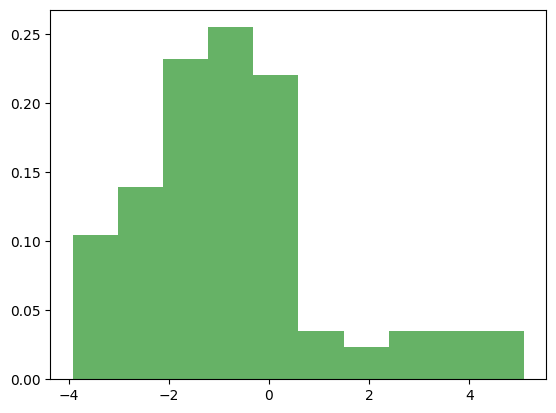

In [35]:
#plot the histogram of the def_pr column
plt.hist(ds['def_pr'], bins=10, density=True, alpha=0.6, color='g', label='def_pr')

In [142]:
path_list = ['C:/Users/colin/Downloads/QUOT_SIM2_latest-20250301-20250426.nc', 'C:/Users/colin/Downloads/QUOT_SIM2_previous-2020-202503.nc']
import xarray as xr
path_list = ['https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/REF_CC/SIM/QUOT_SIM2_previous-2020-202503.csv.gz',
            ' https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/REF_CC/SIM/QUOT_SIM2_2010-2019.csv.gz',
            'https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/REF_CC/SIM/QUOT_SIM2_2000-2009.csv.gz',
            'https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/REF_CC/SIM/QUOT_SIM2_1990-1999.csv.gz',
            'https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/REF_CC/SIM/QUOT_SIM2_1980-1989.csv.gz',
            'https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/REF_CC/SIM/QUOT_SIM2_1970-1979.csv.gz',
            'https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/REF_CC/SIM/QUOT_SIM2_latest-20250301-20250426.csv.gz']

dir_path = 'C:/Users/colin/Downloads/'
path_list = [os.path.join(dir_path, path.split('/')[-1].replace('.csv.gz', '.nc')) for path in path_list]
print(path_list)
ds = xr.open_mfdataset(path_list, combine='nested', concat_dim='time', parallel=True)
ds = ds.sortby('time') 

# ds.to_netcdf('C:/Users/colin/Downloads/QUOT_SIM2_1970-20250426.nc', mode='w', format='NETCDF4', engine='netcdf4')

['C:/Users/colin/Downloads/QUOT_SIM2_previous-2020-202503.nc', 'C:/Users/colin/Downloads/QUOT_SIM2_2010-2019.nc', 'C:/Users/colin/Downloads/QUOT_SIM2_2000-2009.nc', 'C:/Users/colin/Downloads/QUOT_SIM2_1990-1999.nc', 'C:/Users/colin/Downloads/QUOT_SIM2_1980-1989.nc', 'C:/Users/colin/Downloads/QUOT_SIM2_1970-1979.nc', 'C:/Users/colin/Downloads/QUOT_SIM2_latest-20250301-20250426.nc']


In [148]:
ds = ds.sel(ID=['6040_24250', '6920_18250'])
id_list = ['6040_24250', '6920_18250']
ds = ds.load()

In [144]:
ds

<xarray.Dataset>
Dimensions:             (ID: 2, time: 20236)
Coordinates:
  * ID                  (ID) object '6040_24250' '6920_18250'
  * time                (time) datetime64[ns] 1970-01-01 ... 2025-04-26
Data variables:
    precipitation       (ID, time) float64 0.0 0.8 0.2 0.0 ... 0.1 0.0 0.0 0.3
    temperature         (ID, time) float64 -1.9 1.0 2.5 1.4 ... 16.2 16.7 15.9
    temperature_max     (ID, time) float64 0.4 1.9 3.3 1.9 ... 19.7 22.6 18.7
    evapotranspiration  (ID, time) float64 0.8 0.6 0.5 0.7 ... 4.1 5.7 5.5 1.8
    soil_moisture       (ID, time) float64 0.759 0.76 0.763 ... 0.634 0.627

In [ ]:
def parameters_loglogistic(dataframe, column):
    x = dataframe[column].dropna()
    params = fisk.fit(x)
    c, loc, scale = params
    return c, loc, scale

def standardize_loglogistic(c, loc, scale, dataframe, column):
    cdf_values = fisk.cdf(dataframe[column], c, loc=loc, scale=scale)
    cdf_values = np.clip(cdf_values, 1e-6, 1 - 1e-6)
    standardized = norm.ppf(cdf_values)
    dataframe[f"{column}_standardized"] = standardized
    return dataframe



def make_spei(ds):
    # Load the shapefile
    #nuts3 = load_shapefile(shapefile_path, france=True)
    # Get the closest id for each LAU_ID
    #df_closest = closest_id(nuts3)
    # Load the SAFRAN data
    # ds = xr.open_mfdataset(path_list, combine='nested', concat_dim='time', parallel=True)
    # ds = ds.sortby('time') 
    
    # Reproject the data to the shapefile CRS
    ds['def_pr'] = ds['precipitation'] - ds['evapotranspiration']
    ds['def_pr'] = ds['def_pr'].rolling(time=30, center=True).mean()
    ds = ds['def_pr']
    # Initialize lists to store parameters
    def compute_parameters(group):
        # Calculate the log-logistic parameters for the 'def_pr' column
        c, loc, scale = parameters_loglogistic(group, 'def_pr')
        return pd.Series({'c': c, 'loc': loc, 'scale': scale})

    # Group the dataset by 'ID' and compute parameters for each group
    parameters_df = ds.sel(time=slice('1970-01-01', '1999-12-31')).to_dataframe().groupby('ID').apply(compute_parameters).reset_index()

    # Extract the parameters into separate lists
    c_list = parameters_df['c'].tolist()
    loc_list = parameters_df['loc'].tolist()
    scale_list = parameters_df['scale'].tolist()

    #apply the standardization to the dataset
    ds = ds.to_dataframe().reset_index()
    def standardize_group(group, c_list, loc_list, scale_list):
        # Standardize the 'def_pr' column using the log-logistic parameters
        group = standardize_loglogistic(c_list, loc_list, scale_list, group, 'def_pr')
        return group
    # Group the dataset by 'ID' and standardize each group

    ds = ds.groupby('ID').apply(
        lambda group: standardize_group(
            group,
            c_list[parameters_df[parameters_df['ID'] == group.name].index[0]],
            loc_list[parameters_df[parameters_df['ID'] == group.name].index[0]],
            scale_list[parameters_df[parameters_df['ID'] == group.name].index[0]]
        )
    ).reset_index(drop=True)
    ds['year'] = ds['time'].dt.year
    ds['month'] = ds['time'].dt.month
    ds = ds.groupby(['ID', 'year', 'month']).mean().reset_index()
    # ds.to_csv(spei_path, index=False)
    ds.rename(columns={'def_pr_standardized': 'spei'}, inplace=True)
    return ds

def anomaly_temperature(ds):
    # Load the SAFRAN data
    # Reproject the data to the shapefile CRS
    mean = ds.temperature.sel(time=slice('1970-01-01', '1999-12-31')).groupby('time.month').mean(dim='time').to_dataframe().reset_index()
    std = ds.temperature.sel(time=slice('1970-01-01', '1999-12-31')).groupby('time.month').std(dim='time').to_dataframe().reset_index()
    ds = ds[['temperature']].to_dataframe().reset_index()
    mean = mean.rename(columns={'temperature': 'mean'})
    std = std.rename(columns={'temperature': 'std'})

    ds['month'] = ds['time'].dt.month
    ds['mean'] = ds.merge(mean, on=['ID', 'month'], how='left')['mean']
    ds['std'] = ds.merge(std, on=['ID', 'month'], how='left')['std']
    ds['temperature_anomaly'] = (ds['temperature'] - ds['mean']) / ds['std']

    ds['positive_anomaly'] = ds['temperature_anomaly'] > norm.ppf(0.90)
    ds['negative_anomaly'] = ds['temperature_anomaly'] < norm.ppf(0.10)
    ds['year'] = ds['time'].dt.year

    ds = ds[['ID', 'year', 'month', 'positive_anomaly', 'negative_anomaly']].groupby(['ID', 'year', 'month']).sum().reset_index()
    # ds.to_csv(temp_anomaly_path, index=False)
    return ds

In [91]:
df = ds.copy()
df['def_pr'] = df['precipitation'] - df['evapotranspiration']
df['def_pr'] = df['def_pr'].rolling(time=30, center=True).mean()
df = df['def_pr']
# Initialize lists to store parameters
def compute_parameters(group):
    # Calculate the log-logistic parameters for the 'def_pr' column
    c, loc, scale = parameters_loglogistic(group, 'def_pr')
    return pd.Series({'c': c, 'loc': loc, 'scale': scale})

# Group the dataset by 'ID' and compute parameters for each group
parameters_df = df.sel(time=slice('1970-01-01', '1999-12-31')).to_dataframe().groupby('ID').apply(compute_parameters).reset_index()

# Extract the parameters into separate lists
c_list = parameters_df['c'].tolist()
loc_list = parameters_df['loc'].tolist()
scale_list = parameters_df['scale'].tolist()

#apply the standardization to the dataset
df = df.to_dataframe().reset_index()
def standardize_group(group, c_list, loc_list, scale_list):
    # Standardize the 'def_pr' column using the log-logistic parameters
    group = standardize_loglogistic(c_list, loc_list, scale_list, group, 'def_pr')
    return group
# Group the dataset by 'ID' and standardize each group

# df.dropna(inplace=True)
df = df.groupby('ID').apply(
    lambda group: standardize_group(
        group,
        c_list[parameters_df[parameters_df['ID'] == group.name].index[0]],
        loc_list[parameters_df[parameters_df['ID'] == group.name].index[0]],
        scale_list[parameters_df[parameters_df['ID'] == group.name].index[0]]
    )
).reset_index(drop=True)

df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df = df.groupby(['ID', 'year', 'month']).mean().reset_index()

df


C:\Users\colin\AppData\Local\Temp\ipykernel_46892\3287740799.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('ID').apply(


,ID,year,month,time,def_pr,def_pr_standardized
0,1000_23290,1970,1,1970-01-16 00:00:00,2.699792,1.142342
1,1000_23290,1970,2,1970-02-14 12:00:00,2.380476,1.007828
2,1000_23290,1970,3,1970-03-16 00:00:00,0.309462,0.076555
3,1000_23290,1970,4,1970-04-15 12:00:00,-0.294667,-0.238048
4,1000_23290,1970,5,1970-05-16 00:00:00,-1.796452,-1.019978
...,...,...,...,...,...,...
1323,9960_25050,2024,12,2024-12-16 00:00:00,2.274086,1.019817
1324,9960_25050,2025,1,2025-01-16 00:00:00,1.936022,0.839519
1325,9960_25050,2025,2,2025-02-14 12:00:00,0.943690,0.310207
1326,9960_25050,2025,3,2025-03-16 00:00:00,-1.147043,-0.925408


In [145]:
dspei = make_spei(ds)
dspei = dspei.rename(columns={'def_pr_standardized': 'spei'})
#rolling mean on the last 3 months
dspei_roll = dspei[['ID', 'year', 'month', 'spei']].groupby(['ID']).rolling(window=12).mean().reset_index()
dspei_roll['month'] = dspei['month']
dspei_roll['year'] = dspei['year']
dspei_roll = dspei_roll.dropna()
dspei_roll['year'] = dspei_roll['year'].astype(int).astype(str)

C:\Users\colin\AppData\Local\Temp\ipykernel_46892\1812646672.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ds = ds.groupby('ID').apply(


In [146]:
dspei_roll

,ID,level_1,year,month,spei
11,6040_24250,11,1970,12,-0.032513
12,6040_24250,12,1971,1,-0.085810
13,6040_24250,13,1971,2,-0.160250
14,6040_24250,14,1971,3,-0.217084
15,6040_24250,15,1971,4,-0.301727
...,...,...,...,...,...
1323,6920_18250,1323,2024,12,-0.191854
1324,6920_18250,1324,2025,1,-0.206194
1325,6920_18250,1325,2025,2,-0.163602
1326,6920_18250,1326,2025,3,-0.154566


C:\Users\colin\AppData\Local\Temp\ipykernel_46892\420687170.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dplot['cum_months'] = dplot.index - dplot.index[0]
C:\Users\colin\AppData\Local\Temp\ipykernel_46892\420687170.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dplot['cum_months'] = dplot.index - dplot.index[0]


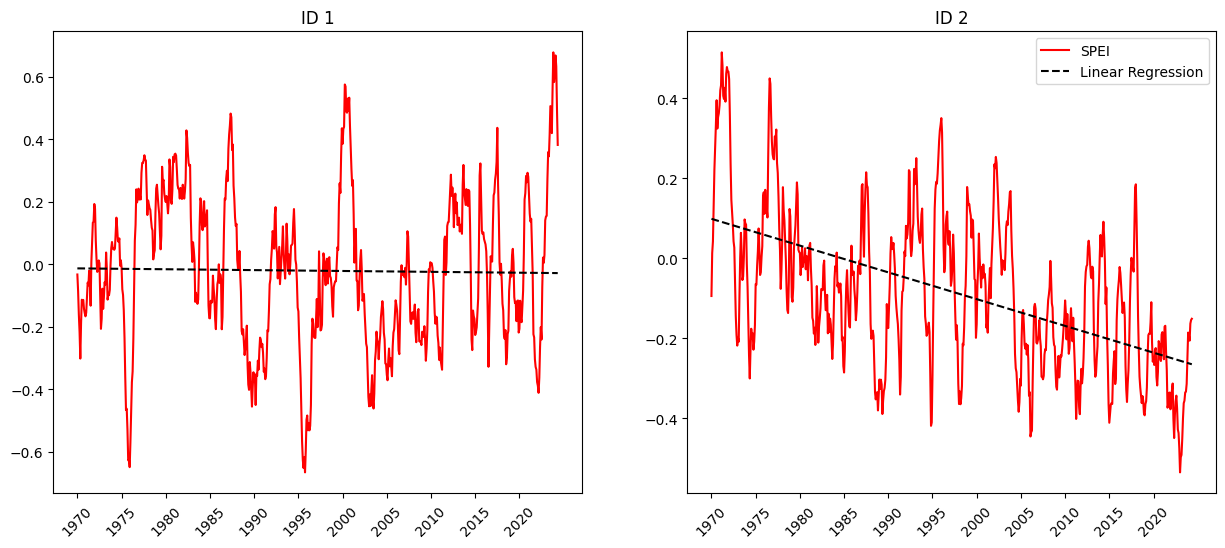

In [149]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(15, 6), sharex=True)

ax = axs[0]
id = id_list[0]
dplot = dspei_roll[dspei_roll['ID'] == id]
ax.plot(dplot['year'].astype(str) + '-' + dplot['month'].astype(str), dplot['spei'], color='red', label='SPEI')
#make the linear regression of the positive anomaly
dplot['cum_months'] = dplot.index - dplot.index[0]
reg = np.polyfit(dplot.cum_months, dplot['spei'], 1)
ax.plot(dplot['year'].astype(str) + '-' + dplot['month'].astype(str), reg[0]*dplot.cum_months + reg[1], color='black', label='Linear Regression', linestyle='--')

ax.set_xticks(dplot['year'].astype(str)[::12*5] + '-' + dplot['month'].astype(str)[::12*5])
ax.set_xticklabels(dplot['year'].astype(str)[::12*5], rotation=45)
ax.set_title('ID 1')

ax = axs[1]
id = id_list[1]
dplot = dspei_roll[dspei_roll['ID'] == id]
ax.plot(dplot['year'].astype(str) + '-' + dplot['month'].astype(str), dplot['spei'], color='red', label='SPEI')
#make the linear regression of the positive anomaly
dplot['cum_months'] = dplot.index - dplot.index[0]
reg = np.polyfit(dplot.cum_months, dplot['spei'], 1)
ax.plot(dplot['year'].astype(str) + '-' + dplot['month'].astype(str), reg[0]*dplot.cum_months + reg[1], color='black', label='Linear Regression', linestyle='--')
ax.set_title('ID 2')

ax.set_xticks(dplot['year'].astype(str)[::12*5] + '-' + dplot['month'].astype(str)[::12*5])
ax.set_xticklabels(dplot['year'].astype(str)[::12*5], rotation=45)
ax.legend()


In [150]:
dtemp = anomaly_temperature(ds)
dtemp['negative_anomaly'] = -1*dtemp['negative_anomaly']

C:\Users\colin\AppData\Local\Temp\ipykernel_46892\3857828556.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dplot['cum_months'] = dplot.index - dplot.index[0]
C:\Users\colin\AppData\Local\Temp\ipykernel_46892\3857828556.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dplot['cum_months'] = dplot.index - dplot.index[0]


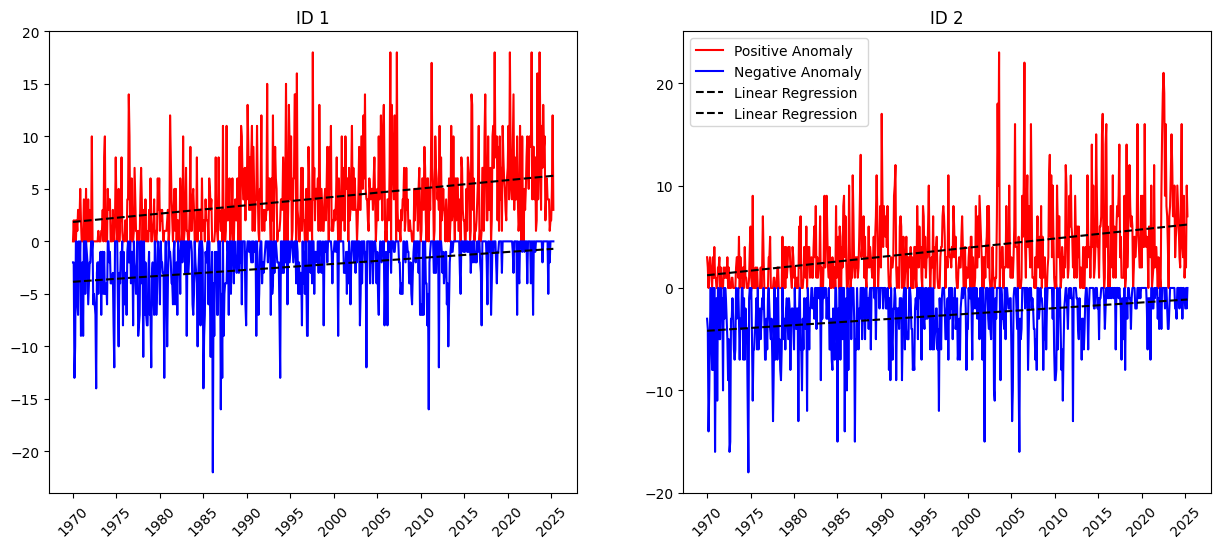

In [151]:
#plot the evolution of the temperature anomaly for each ID in blue and negative the negative anomaly in red and the positive in green
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(15, 6), sharex=True)

ax = axs[0]
id = id_list[0]
dplot = dtemp[dtemp['ID'] == id]
ax.plot(dplot['year'].astype(str) + '-' + dplot['month'].astype(str), dplot['positive_anomaly'], color='red', label='Positive Anomaly')
ax.plot(dplot['year'].astype(str) + '-' + dplot['month'].astype(str), dplot['negative_anomaly'], color='blue', label='Negative Anomaly')
#make the linear regression of the positive anomaly
dplot['cum_months'] = dplot.index - dplot.index[0]
reg = np.polyfit(dplot.cum_months, dplot['positive_anomaly'], 1)
ax.plot(dplot['year'].astype(str) + '-' + dplot['month'].astype(str), reg[0]*dplot.cum_months + reg[1], color='black', label='Linear Regression', linestyle='--')
ax.set_title('ID 1')
reg = np.polyfit(dplot.cum_months, dplot['negative_anomaly'], 1)
ax.plot(dplot['year'].astype(str) + '-' + dplot['month'].astype(str), reg[0]*dplot.cum_months + reg[1], color='black', label='Linear Regression', linestyle='--')
ax.set_xticks(dplot['year'].astype(str)[::12*5] + '-' + dplot['month'].astype(str)[::12*5])
ax.set_xticklabels(dplot['year'].astype(str)[::12*5], rotation=45)

ax = axs[1]
id = id_list[1]
dplot = dtemp[dtemp['ID'] == id]
ax.plot(dplot['year'].astype(str) + '-' + dplot['month'].astype(str), dplot['positive_anomaly'], color='red', label='Positive Anomaly')
ax.plot(dplot['year'].astype(str) + '-' + dplot['month'].astype(str), dplot['negative_anomaly'], color='blue', label='Negative Anomaly')
#make the linear regression of the positive anomaly
dplot['cum_months'] = dplot.index - dplot.index[0]
reg = np.polyfit(dplot.cum_months, dplot['positive_anomaly'], 1)
ax.plot(dplot['year'].astype(str) + '-' + dplot['month'].astype(str), reg[0]*dplot.cum_months + reg[1], color='black', label='Linear Regression', linestyle='--')
ax.set_title('ID 2')
reg = np.polyfit(dplot.cum_months, dplot['negative_anomaly'], 1)
ax.plot(dplot['year'].astype(str) + '-' + dplot['month'].astype(str), reg[0]*dplot.cum_months + reg[1], color='black', label='Linear Regression', linestyle='--')
ax.set_xticks(dplot['year'].astype(str)[::12*5] + '-' + dplot['month'].astype(str)[::12*5])
ax.set_xticklabels(dplot['year'].astype(str)[::12*5], rotation=45)
ax.legend()
